# 선형 회귀를 처음부터 구현하기

선형 회귀에 대한 어느 정도의 배경 지식을 습득했으니 이제 실제 구현을 해보도록 하겠습니다. 좋은 딥러닝 프레임워크를 이용하면 반복적인 일을 줄일 수 있지만, 일을 쉽게 하기 위해서 프레임워크에 너무 의존하면 딥러닝이 어떻게 동작하는지 이해하기 어렵게 될 수 있습니다. 예를 들면, 이후에 레이어, loss 함수 등을 직접 정의해야하는 경우에 특히 그렇습니다. 따라서, NDArray와  `autograd` 만을 이용해서 선형 회귀 학습을 직접 구현해보겠습니다.

시작하기 앞서, 이 절에서 필요한 패키지와 모듈을 import 합니다. `matplotlib` 는 도표를 그리고 화면에 표시하는데 사용됩니다.

In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

## 데이터셋 생성하기

간단한 학습 데이터셋을 직접 만들어서 학습된 파라미터와 실제 모델의 파라미터의 차이를 시각적으로 비교해볼 수 있습니다. 학습 데이터셋의 샘플 개수는 1000개로 하고, 특성(feature) 개수는 2개로 합니다. 임의로 생성한 배치 샘플 특성(feature)  $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$ 와 실제 가중치 값 $\mathbf{w} = [2, -3.4]^\top$ 와 편향(bias) $b = 4.2$ 를 사용하겠습니다. 그리고, 임의의 노이즈 값 $\epsilon$ 도 사용합니다.

$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon​$$

노이즈 항목  $\epsilon$ 은 평균이 0이고 표준편차가 0.01인 정규 분포를 따르도록 정의합니다. 아래 코드로 실제 데이터셋을 생성합니다.

In [2]:
num_inputs = 2
num_examples = 1000
true_w = nd.array([2, -3.4])
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

`features` 의 각 행은 2차원 데이터 포인트로 구성되고,  `labels` 의 각 행은 1차원 타겟 값으로 구성됩니다.

In [3]:
features[0], labels[0]

(
 [2.2122064 0.7740038]
 <NDArray 2 @cpu(0)>, 
 [6.000587]
 <NDArray 1 @cpu(0)>)

`features[:, 1]` 과 `labels` 를 이용해서 scatter plot을 생성해보면, 둘 사이의 선형 관계를 명확하게 관찰할 수 있습니다.

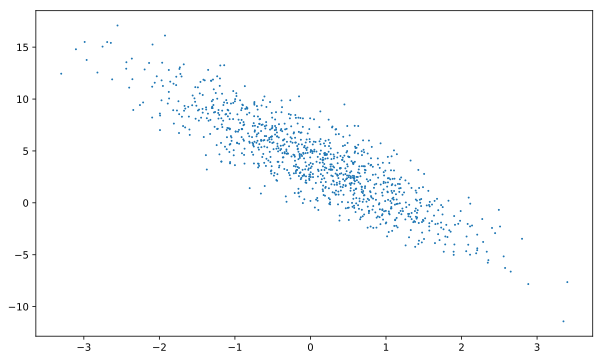

In [4]:
def use_svg_display():
    # Display in vector graphics
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # Set the size of the graph to be plotted
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.figure(figsize=(10, 6))
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);

plot을 그려주는 함수 `plt`,  `use_svg_display` 함수와 `set_figsize` 함수는 `g2l` 패키지에 정의되어 있습니다. 앞으로는 plot을 그리기 위해서  `g2l.plt` 를 직접 호출하겠습니다.  `plt` 은  `g2l` 패키지의 전역 변수로 정의되어 있기 때문에, 벡터 다이어그램과 크기를 정하기 위해서는 plot을 그리기 전에  `g2l.set_figsize()` 를 호출하면 됩니다. 

## 데이터 읽기

모델을 학습시킬 때, 전체 데이터셋을 반복적으로 사용하면서 각 데이터의 미니 배치를 얻어야 합니다. 이를 위해서 함수를 하나 정의하겠습니다. 이 함수는 임의로 선택된 특성(feature)들과 태그(tag)들을 배치 크기(batch size)의 개수만큼 리턴해주는 역할을 합니다. 왜 한번에 하나의 샘플을 사용하지 않고 여러 샘플을 리턴하는 iterator를 작성할까요? 이유는 최적화를 효율적으로 하기 위함입니다. 한번에 하나의 1-차원 값을 처리했을 때 성능이 아주 느렸던 것을 기억해볼까요. 하나의 샘플을 처리하는 것처럼, 하나의 벡터가 아닌 행렬로 표현된 샘플들의 전체 배치를 한번에 처리하는 것도 동일하게 할 수 있습니다. 특히, GPU는 행렬을 다룰 때 아주 빠른 속도로 연산을 수행합니다. 이것이 딥러닝에서 보통 하나의 샘플 보다는 미니 배치 단위로 연산을 하는 이유 중에 하나입니다.

In [5]:
# This function has been saved in the d2l package for future use
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # The “take” function will then return the corresponding element based
        # on the indices

첫번째 작은 배치를 읽어서 출력해보겠습니다. 각 배치의 특성(feature)들의 모양(shape)은 배치 크기와 입력 차원의 수와 연관됩니다. 마찬가지로, 배치 크기와 동일한 레이블(label)들을 얻습니다.

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-0.30573937 -0.9590651 ]
 [ 0.07364878 -0.00326891]
 [-0.4814555  -0.91107726]
 [ 1.0380163   0.8255258 ]
 [-0.11494503  1.7983674 ]
 [ 0.3341707  -0.17603478]
 [-0.67570597 -1.0531636 ]
 [ 0.3943117  -1.0634161 ]
 [-1.2562267   0.5766641 ]
 [ 0.52217364 -0.96701854]]
<NDArray 10x2 @cpu(0)> 
[ 6.8569913  4.37563    6.332793   3.4770956 -2.1227243  5.474708
  6.429421   8.621504  -0.2830314  8.526825 ]
<NDArray 10 @cpu(0)>


당연하겠지만, iterator를 다시 수행하면, 전체 데이터를 모두 소진할 때까지 다른 미니 배치를 반환합니다. 위에서 구현한 iterator는 다소 비효율적입니다 (모든 데이터를 메모리에 로딩한 후, 메모리를 접근하는 것을 반복하기 때문입니다.) 패키지에서 제공하는 iterator는 더 효율적으로 구현되어 있고, 파일에 저장된 데이터를 접근하거나 데이터 스트림을 통한 접근도 가능합니다.

## 모델 파라미터들 초기화하기

가중치는 평균값이 0이고 표준편차가 0.01인 정규분포를 따르는 난수값들로 초기화합니다. 편향(bias) $b$ 는 0으로 설정합니다.

In [7]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1,))

이후, 모델이 데이터를 잘 예측할 수 있도록 이 파라미터들을 업데이트할 것입니다. 이를 위해서 손실 함수(loss function)의 파라미터에 대한 그래디언트(gradient), 즉 다변수 미분을 구해야 합니다. 손실(loss) 값을 줄이는 방향으로 각 파라미터를 업데이트 할 것입니다.  `autograd` 가 적당한 데이터 구조를 준비하고, 변경을 추적할 수 있도록, 그래디언트(gradient)들을 명시적으로 붙여줘야 합니다.

In [8]:
w.attach_grad()
b.attach_grad()

## 모델 정의하기

다음으로는 모델을 정의합니다. 아주 간단하고 유용한 뉴럴 네트워크인 선형 모델을 정의하겠습니다. 선형 모델의 결과를 계산하기 위해서, 입력 값과 모델의 가중치 $w$ 를 곱하고 오프셋(offset) $b$ 를 더합니다.

In [9]:
# This function has been saved in the d2l package for future use
def linreg(X, w, b):
    return nd.dot(X, w) + b

## 손실 함수(loss function) 정의하기

이전 절에서 선형 회귀 손실(loss)를 정의하는데 사용한 제곱 손실 함수(squared loss function)를 사용하겠습니다. 이를 구현하기 위해서 우선 실제 값  `y`  의 모양(shape)을 예측 값 `y_hat`의 모양(shape)과 동일하게 변형합니다. 다음 함수의 리턴 값은 `y_hat` 의 모양(shape)과 동일하게 바꿉니다.

In [10]:
# This function has been saved in the d2l package for future use
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 최적화 알고리즘 정의하기

선형 회귀 문제는 잘 정의된 솔루션이 있습니다. 하지만, 우리가 다루게 될 많은 재미있는 모델은 분석적인 방법으로 풀릴 수 없습니다. 그렇기 때문에, 이 문제를 확률적 경사 하강법(stochastic gradient descent)  `sgd` 를 이용해서 풀어볼 것입니다. 각 단계에서 데이터셋 중 임의로 선택한 배치를 이용해서, 가중치(weight)들에 대한 손실(loss)의 그래디언트(gradient)를 추정합니다. 그리고, 손실(loss)을 줄이는 방향으로 파라미터들을 조금씩 업데이트합니다. 여기서, 자동 미분 모듈로 계산된 그래디언트(gradient)는 샘플들의 배치의 그래디언트(gradient) 합입니다. 평균을 구하기 위해서, 이 값을 배치 크기로 나누고, 학습 속도(learning rate)  `lr`  로 정의된 값에 비례해서 업데이트를 하게 됩니다.

In [11]:
# This function has been saved in the d2l package for future use
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

## 학습

학습은 데이터를 반복해서 사용하면서 모델의 파라미터를 최적화시키는 것입니다. 각 반복에서는 현재 얻어진 미니 배치의 데이터 샘플들 (피처 `X` 와 레이블 `y`)을 이용해서 역함수인  `backward` 함수를 호출해서 미니 배치에 대한 확률적 경사(stochastic gradient)를 계산합니다. 이후, 최적화 알고리즘 `sgd` 을 호출해서 모델 파라미터들을 업데이트 하게 됩니다. 앞의 소스 코드에서 배치 크기  `batch_size` 를 10으로 설정했으니, 각 미니 배치별로 손실(loss) `l` 의 모양(shape)은 (10,1)이 됩니다.

* 파라미터 $(\mathbf{w}, b)$ 를 초기화합니다.
* 끝날 때까지 다음을 반복합니다.
    * 그래디언트(gradient) 계산하기 $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{\mathcal{B}} \sum_{i \in \mathcal{B}} l(\mathbf{x}^i, y^i, \mathbf{w}, b)$
    * 파라미터 업데이트하기 $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

그래디언트(gradient)를 계산하는 코드를 직접 작성해야 한다면, 지루하기도 하고 코드에 오류가 있을 수 있기 때문에, $g$ 를 계산해주는 자동 미분(automatic differentiation)을 이용합니다. 이에 대한 자세한 내용은  ["Automatic Gradient"](../chapter_prerequisite/autograd.ipynb)  절을 참조하세요. loss `l` 은 스칼라 변수가 아니기 때문에,  `l.backward()` 를 수행하면  `l` 의 모든 항목들을 합해서 새로운 변수를 만들고, 이를 이용해서 다양한 모델 파라미터의 gradient를 계산합니다.

매 epoch 마다,  `data_iter` 함수를 이용해서 학습 데이터셋의 전체 샘플을 한 번씩 학습에 사용합니다. 이 때, 전체 샘플의 개수는 배치 크기의 배수라고 가정합니다. 하이퍼파라미터(hyper-parameter)인 총 epoch 수  `num_epochs`  와 학습 속도(learning rate)  `lr` 는 각 각 3, 0.03으로 설정합니다. 실제 상황에서는 하이퍼파라미터(hyper-parameter)들은 반복된 실험을 통해서 가장 좋은 값을 직접 찾아야합니다. 예를 들면, 어떤 모델은 학습을 오래하면 정확도가 높아지기도 합니다. 물론 이 때, 연산 비용이 증가하게 됩니다. 마찬가지로, 학습을 수행하는 중간에 학습 속도(learning rate)를 변경하고 싶은 경우도 있습니다. 이에 대한 내용은  ["최적화 알고리즘, Optimization Algorithms"](../chapter_optimization/index.ipynb) 에서 자세히 살펴보겠습니다.

In [12]:
lr = 0.03  # Learning rate
num_epochs = 3  # Number of iterations
net = linreg  # Our fancy linear model
loss = squared_loss  # 0.5 (y-y')^2

for epoch in range(num_epochs):
    # Assuming the number of examples can be divided by the batch size, all
    # the examples in the training data set are used once in one epoch
    # iteration. The features and tags of mini-batch examples are given by X
    # and y respectively
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)  # Minibatch loss in X and y
        l.backward()  # Compute gradient on l with respect to [w,b]
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.040686


epoch 2, loss 0.000156


epoch 3, loss 0.000050


학습된 모델을 평가하는 방법으로 실제 파라미터와 학습을 통해서 찾아낸 파라미터를 비교해보면, 이것들이 매우 비슷해졌습니다.

In [13]:
print('Error in estimating w', true_w - w.reshape(true_w.shape))
print('Error in estimating b', true_b - b)

Error in estimating w 
[ 0.00027239 -0.00038648]
<NDArray 2 @cpu(0)>
Error in estimating b 
[0.00033998]
<NDArray 1 @cpu(0)>


모델의 파라미터를 아주 정확하게 찾아내는 것이 간단한 일은 아닙니다. 아주 특별한 분류의 문제에서만 간단히 찾는 것이 가능합니다. 예를 들면, 노이즈가 있는 샘플들을 이용해도 숨겨진 상관관계를 정확하게 찾아낼 수 있을 정도로 많은 양의 데이터가 주어진 강한 볼록 최적화(strongly convex optimzation) 문제가 그런 경우 입니다. 대부분의 경우, 문제는 이런 분류가 아닙니다. 실제로는 학습 데이터가 사용되는 순서를 포함해서 모든 경우가 동일하지 않은 경우가 아니면 딥 네트워크의 파라미터들이 비슷하거나 같게 나오지 않습니다. 그럼에도 불구하고, 뉴럴 네트워크는 좋은 모델을 만들어내는데, 이는 예측을 잘하는 여러 파라미터 집합들이 존재하기 때문입니다.

## 요약

이 절에서 NDArray와  `autograd`  만을 사용해서 레이어 정의나 멋진 옵티마이져(optimizer)를 위한 별도의 도구 없이도 딥 네트워크 구현 및 최적화를 어떻게 할 수 있는지 살펴봤습니다. 이 예제는 어떤 것들이 가능한지에 대한 기본만 다뤘고, 다음 절에서는 지금까지 배운 것들을 기반으로 다양한 딥 러닝 모델들을 살펴보고, 보다 간결하게 구현하는 방법에 대해서 살펴보겠습니다.

## 문제

1. 가중치(weight)들을 0으로 ($\mathbf{w} = 0$) 초기화를 하면 어떤 일이 발생할까요? 알고리즘이 여전히 동작할까요?
1. 여러분이 전압과 전류간의 모델을 만들고자 하는 [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) 이라고 가정해 보세요. 여러분의 모델 파라미터를 학습시키기 위해서 `autograd` 를 사용할 수 있을까요?
1. 스펙트럼 에너지 밀도를 사용해서 물체의 온도를 결정하는 데 [Planck's Law](https://en.wikipedia.org/wiki/Planck%27s_law) 를 사용할 수 있나요?
1. `autograd` 를 이차 미분으로 확장한다면 어떤 문제를 만날 수 있을까요?
1. `squared_loss` 함수에서 `reshape` 함수가 왜 필요한가요?
1. 다양한 학습 속도(learning rate)들을 사용해서 실험하고, 그 결과 손실 함수(loss function) 값이 얼마나 빠르게 감소하는지 알아보세요.
1. 예제들의 개수가 배치 크기로 나누어 떨어지지 않을 경우에, `data_iter` 함수는 어떻게 동작할까요?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2332)

![](../img/qr_linear-regression-scratch.svg)